<a href="https://colab.research.google.com/github/ajaysinha1804/nailDiseasesAnalysis/blob/main/ResNet_50_with_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependecies


In [ ]:
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D
from keras import regularizers, optimizers
import numpy as np
from keras.layers import Add
from keras.layers import Input
from keras.models import Model
from keras.layers import Flatten
from keras.utils import plot_model
from keras.preprocessing import image
import os
import re
from sklearn.model_selection import train_test_split
from keras.applications.imagenet_utils import preprocess_input
from sklearn.utils import shuffle
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
import keras
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/datasetnew/"
METRICS_PATH="/content/drive/MyDrive/metro/"
MODEL_NAME="ResNet"
print("PWD", PATH)

PWD /content/drive/MyDrive/datasetnew/


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from Drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['Acral Lentiginous Melanoma', 'Bluish Nail', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Nail Pitting', 'Onychogryphosis', 'onycholysis']


In [ ]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        # print(img)
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        #     x = x/255
        # print('Input image shape:', x.shape)
        img_data_list.append(x)

Loaded the images of dataset-Acral Lentiginous Melanoma

Loaded the images of dataset-Bluish Nail

Loaded the images of dataset-Clubbing

Loaded the images of dataset-Healthy Nail

Loaded the images of dataset-Koilonychia

Loaded the images of dataset-Nail Pitting

Loaded the images of dataset-Onychogryphosis

Loaded the images of dataset-onycholysis



In [ ]:
img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(8033, 1, 32, 32, 3)
(1, 8033, 32, 32, 3)
(8033, 32, 32, 3)


# Train & Test Data

In [ ]:
num_classes = 8
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:859] = 0
labels[859:2191] = 1
labels[2191:3380] = 2
labels[3380:4222] = 3
labels[4222:5121] = 4
labels[5121:5865] = 5
labels[5865:7269] = 6
labels[7269:8033] = 7

names = ['Acral Lentiginous Melanoma', 'Bluish Nail', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Nail Pitting', 'Onychogryphosis', 'onycholysis']

sample 8033


In [ ]:
Y = to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [ ]:
def initial_conv(Input, filters, stride=1, kernel_size=7):
    x = Conv2D(filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), padding="same")(Input)

    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    return x


def expand_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    Init = Input

    # First conv which is used to downsample the image
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut to make skip connection(Paper terminology)
    skip_conv = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])
    return x


def normal_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def expand_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut
    skip_conv = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])

    return x

def normal_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 Conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #    x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def build_basic_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                       first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_basic_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_basic_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_basic_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_basic_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_basic_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_basic_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_basic_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r4 - 1):
        x = normal_conv_basic_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    # Classifier Block
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


def build_bottleneck_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                            first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_bottleneck_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_bottleneck_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_bottleneck_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_bottleneck_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_bottleneck_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_bottleneck_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_bottleneck_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv4
    for i in range(r4 - 1):
        x = normal_conv_bottleneck_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)

    # Classifier Block
    x = Flatten()(x)
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


In [ ]:
model = build_bottleneck_resnet(32,32,8,3,4,6,3,2,True,7)
model.summary()
plot_model(model,"ResNet50.png",show_shapes=True)
model.compile(loss='categorical_crossentropy',
        optimizer="Adam",
        metrics=['accuracy',f1,sensitivity,specificity])


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_53 (Conv2D)          (None, 16, 16, 64)           9472      ['image_input[0][0]']         
                                                                                                  
 batch_normalization_53 (Ba  (None, 16, 16, 64)           256       ['conv2d_53[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_49 (Activation)  (None, 16, 16, 64)           0         ['batch_normalization_53

In [ ]:
METRICS_PATH+MODEL_NAME+".csv"

'/content/drive/MyDrive/metro/ResNet.csv'

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")

model_chekpoint = ModelCheckpoint("ResNet50_DA_aug.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


# Model Training

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
import time
start = time.time()

if data_augmentation:
    print("-------------Using Data augmentation------------")
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images

    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs, verbose=1, validation_data=(x_test, y_test),
                        callbacks=[lr_reducer,  csv_logger, model_chekpoint])

else:
    print("-----Not Using Data augmentation---------------")
    history = model.fit(x_train, y_train,
              batch_size=batch_size * 4,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,  csv_logger, model_chekpoint])


-------------Using Data augmentation------------
Epoch 1/100


<ipython-input-19-2c13fe4e579f>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


401/401 [==============================] - ETA: 0s - loss: 2.6334 - accuracy: 0.2796 - f1: 0.1283 - sensitivity: 0.0854 - specificity: 0.9779
Epoch 1: val_loss improved from inf to 2.68616, saving model to ResNet50_DA_aug.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - 73s 83ms/step - loss: 2.6334 - accuracy: 0.2796 - f1: 0.1283 - sensitivity: 0.0854 - specificity: 0.9779 - val_loss: 2.6862 - val_accuracy: 0.3528 - val_f1: 0.2973 - val_sensitivity: 0.2222 - val_specificity: 0.9626 - lr: 0.0010
Epoch 2/100
400/401 [============================>.] - ETA: 0s - loss: 2.3968 - accuracy: 0.2573 - f1: 0.1123 - sensitivity: 0.0733 - specificity: 0.9839
Epoch 2: val_loss did not improve from 2.68616
401/401 [==============================] - 24s 61ms/step - loss: 2.3951 - accuracy: 0.2576 - f1: 0.1123 - sensitivity: 0.0733 - specificity: 0.9839 - val_loss: 3.5196 - val_accuracy: 0.2576 - val_f1: 0.1328 - val_sensitivity: 0.0804 - val_specificity: 0.9849 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 2.4488 - accuracy: 0.2159 - f1: 0.0385 - sensitivity: 0.0223 - specificity: 0.9889
Epoch 3: val_loss improved from 2.68616 to 2.15302, saving model to ResNet50_DA_aug.hdf5
401/401 [===

# Results

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 3302.1891515254974
51/51 [==============================] - 1s 14ms/step - loss: 1.3701 - accuracy: 0.5426 - f1: 0.4508 - sensitivity: 0.3335 - specificity: 0.9807
dict_keys(['loss', 'accuracy', 'f1', 'sensitivity', 'specificity', 'val_loss', 'val_accuracy', 'val_f1', 'val_sensitivity', 'val_specificity', 'lr'])
dict_values([[2.633359432220459, 2.3950555324554443, 2.4488022327423096, 2.447218894958496, 2.4699039459228516, 2.433532953262329, 2.3833234310150146, 2.014056921005249, 1.9867945909500122, 1.945122241973877, 1.8554577827453613, 1.8127127885818481, 1.7819085121154785, 1.72444486618042, 1.621240258216858, 1.593187689781189, 1.5513842105865479, 1.5257184505462646, 1.5151028633117676, 1.486080527305603, 1.468904972076416, 1.457303524017334, 1.448814868927002, 1.4327421188354492, 1.418986439704895, 1.4069701433181763, 1.3960468769073486, 1.3960728645324707, 1.4148533344268799, 1.397768497467041, 1.4059710502624512, 1.3897771835327148, 1.39313

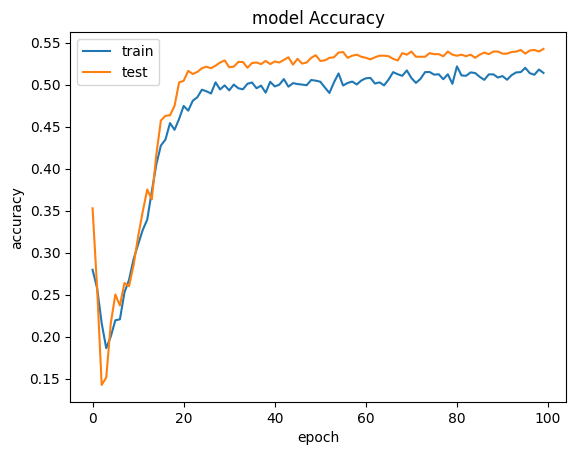

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


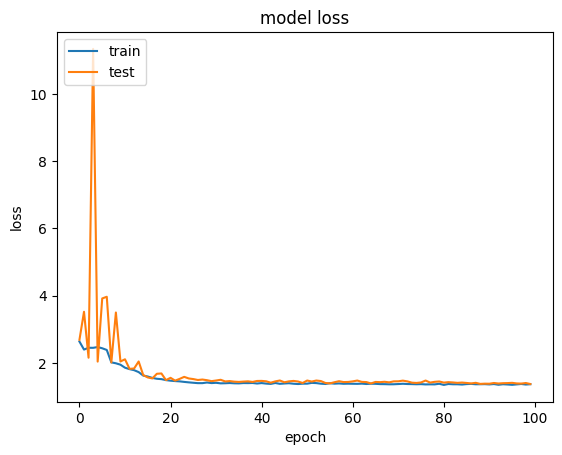

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


Without Augmentation

In [ ]:
PATH = "/content/drive/MyDrive/datasetnew/"
METRICS_PATH="/content/drive/MyDrive/metro/"
MODEL_NAME="ResNet_wag"
print("PWD", PATH)


PWD /content/drive/MyDrive/datasetnew/


In [ ]:
def initial_conv(Input, filters, stride=1, kernel_size=7):
    x = Conv2D(filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), padding="same")(Input)

    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    return x


def expand_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    Init = Input

    # First conv which is used to downsample the image
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut to make skip connection(Paper terminology)
    skip_conv = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])
    return x


def normal_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def expand_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut
    skip_conv = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])

    return x

def normal_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 Conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #    x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def build_basic_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                       first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_basic_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_basic_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_basic_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_basic_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_basic_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_basic_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_basic_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r4 - 1):
        x = normal_conv_basic_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    # Classifier Block
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


def build_bottleneck_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                            first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_bottleneck_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_bottleneck_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_bottleneck_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_bottleneck_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_bottleneck_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_bottleneck_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_bottleneck_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv4
    for i in range(r4 - 1):
        x = normal_conv_bottleneck_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)

    # Classifier Block
    x = Flatten()(x)
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


In [ ]:
model = build_bottleneck_resnet(32,32,8,3,4,6,3,2,True,7)
model.summary()
plot_model(model,"ResNet50_wag.png",show_shapes=True)
model.compile(loss='categorical_crossentropy',
        optimizer="Adam",
        metrics=['accuracy',f1,sensitivity,specificity])


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_106 (Conv2D)         (None, 16, 16, 64)           9472      ['image_input[0][0]']         
                                                                                                  
 batch_normalization_106 (B  (None, 16, 16, 64)           256       ['conv2d_106[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_98 (Activation)  (None, 16, 16, 64)           0         ['batch_normalization_10

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("ResNet50_F1score_DA_aug.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


In [ ]:

batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
import time
start = time.time()

if data_augmentation:
    print("-------------Using Data augmentation------------")
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images

    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs, verbose=1, validation_data=(x_test, y_test),
                        callbacks=[lr_reducer,  csv_logger, model_chekpoint])

else:
    print("-----Not Using Data augmentation---------------")
    history = model.fit(x_train, y_train,
              batch_size=batch_size * 4,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,  csv_logger, model_chekpoint])


-----Not Using Data augmentation---------------
Epoch 1/100
101/101 [==============================] - ETA: 0s - loss: 2.2309 - accuracy: 0.3136 - f1: 0.1361 - sensitivity: 0.0868 - specificity: 0.9816
Epoch 1: val_loss improved from inf to 2.01674, saving model to ResNet50_F1score_DA_aug.hdf5
101/101 [==============================] - 45s 97ms/step - loss: 2.2309 - accuracy: 0.3136 - f1: 0.1361 - sensitivity: 0.0868 - specificity: 0.9816 - val_loss: 2.0167 - val_accuracy: 0.2110 - val_f1: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
100/101 [============================>.] - ETA: 0s - loss: 1.6763 - accuracy: 0.4830 - f1: 0.3892 - sensitivity: 0.2820 - specificity: 0.9784
Epoch 2: val_loss did not improve from 2.01674
101/101 [==============================] - 5s 51ms/step - loss: 1.6784 - accuracy: 0.4829 - f1: 0.3895 - sensitivity: 0.2830 - specificity: 0.9779 - val_loss: 2.2093 - val_accuracy: 0.2993 - val_f1: 0.2284 - val_sensitivity:

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 639.5264360904694
51/51 [==============================] - 1s 14ms/step - loss: 1.9838 - accuracy: 0.6665 - f1: 0.6702 - sensitivity: 0.6620 - specificity: 0.9554
dict_keys(['loss', 'accuracy', 'f1', 'sensitivity', 'specificity', 'val_loss', 'val_accuracy', 'val_f1', 'val_sensitivity', 'val_specificity', 'lr'])
dict_values([[2.2308740615844727, 1.678444743156433, 1.8436875343322754, 1.1823880672454834, 0.8984947204589844, 0.6553383469581604, 0.5230430364608765, 0.21110355854034424, 0.10484760254621506, 0.06273987889289856, 0.04644503444433212, 0.03689739108085632, 0.031567174941301346, 0.027706464752554893, 0.023647209629416466, 0.027841966599225998, 0.019263980910182, 0.03221552073955536, 0.021648282185196877, 0.0276666060090065, 0.02064565196633339, 0.02647976018488407, 0.021669210866093636, 0.021545320749282837, 0.02477939799427986, 0.019284304231405258, 0.019447172060608864, 0.018026279285550117, 0.022492239251732826, 0.016869578510522842, 0.

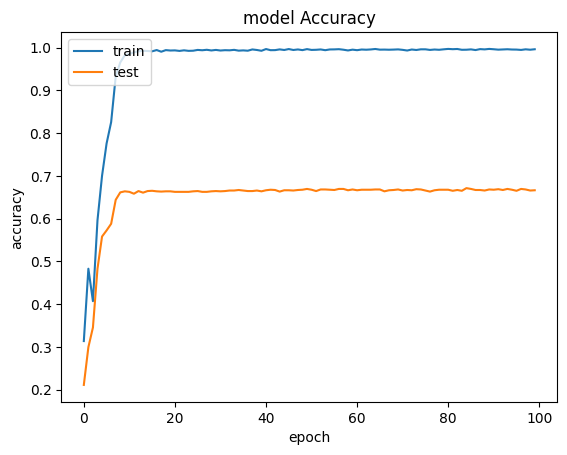

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


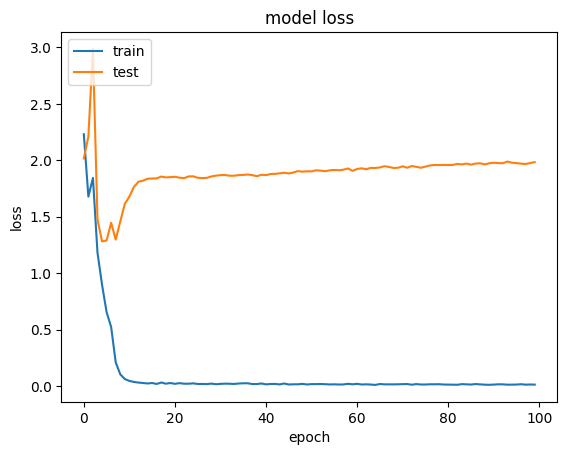

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
